In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [2]:
data=pd.read_csv('datasets/pokemon.csv')
data

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,NaN
807,meltan,Steel,NaN


In [3]:
data.value_counts('Type1')

Type1
Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Rock         46
Electric     40
Poison       34
Ground       32
Fighting     29
Dark         29
Ghost        27
Dragon       27
Steel        26
Ice          23
Fairy        18
Flying        3
dtype: int64

In [4]:
data=data[data.Type1.isin(['Water','Grass','Fire'])][['Name','Type1']]
data

,Name,Type1
0,bulbasaur,Grass
1,ivysaur,Grass
2,venusaur,Grass
3,charmander,Fire
4,charmeleon,Fire
...,...,...
778,bruxish,Water
786,tapu-bulu,Grass
787,tapu-fini,Water
797,kartana,Grass


In [5]:
print('Data shape',data.shape)
print('Number of unique names',data.Name.nunique())

Data shape (245, 2)
Number of unique names 245


In [6]:
import os
import pandas as pd
import cv2

image_df = pd.DataFrame({'Name':[],'img':[]})


path_start='datasets/images'
for filename in os.listdir(path_start):
    if filename.endswith(".png"):
        image_name = filename.split('.')[0]  
        
        image = cv2.imread(os.path.join(path_start, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        image_df=image_df.append({'Name':image_name,'img':np.array(image)},ignore_index=True)
        
        
        
        
        
        

In [7]:
data=data.merge(image_df,how='inner', on='Name')

In [8]:
data.img.info()

<class 'pandas.core.series.Series'>
Int64Index: 218 entries, 0 to 217
Series name: img
Non-Null Count  Dtype 
--------------  ----- 
218 non-null    object
dtypes: object(1)
memory usage: 3.4+ KB


In [9]:
data.value_counts('Type1')

Type1
Water    105
Grass     66
Fire      47
dtype: int64

In [10]:
data.loc[0].img.shape

(120, 120, 3)

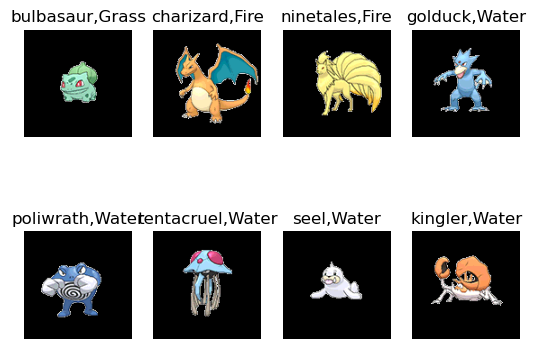

In [11]:
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(data.loc[i*5].img)
    plt.title(f"{data.loc[i*5].Name},{data.loc[i*5].Type1}")
    plt.axis('off')
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
X=np.array(data['img'].tolist(), dtype = np.float32)/255.0
y=data['Type1']

In [13]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


augmented_images = []
augmented_labels = []


for i in range(len(X)):
    image = X[i]
    label = y[i]
    image = np.expand_dims(image, axis=0)
    label = np.array([label])
    augmented_images_batch, augmented_labels_batch = [], []
    j=0
    for x_batch, y_batch in datagen.flow(image, label, batch_size=4):
        augmented_images_batch.extend(x_batch)
        augmented_labels_batch.extend(y_batch)
        j+=1
        if j>3:
            break
    augmented_images.extend(augmented_images_batch)
    augmented_labels.extend(augmented_labels_batch)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [14]:
print(X.shape)
print(augmented_images.shape)

(218, 120, 120, 3)
(872, 120, 120, 3)


In [15]:
X=np.concatenate((X, augmented_images), axis=0)
y=np.concatenate((y,augmented_labels), axis=0)
print(X.shape)

(1090, 120, 120, 3)


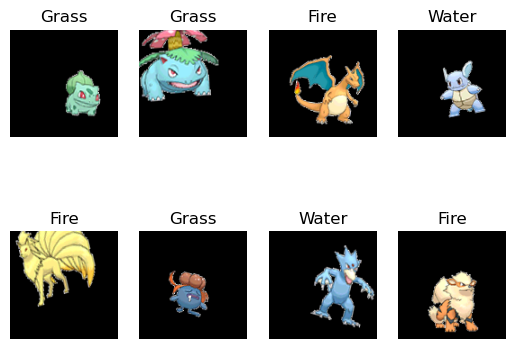

In [16]:
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(augmented_images[i*10])
    plt.title(f"{augmented_labels[i*10]}")
    plt.axis('off')
plt.show()

In [17]:
labels_dict={'Water': 0, 'Grass': 1, 'Fire': 2}


y_final = []
for yi in y:
    y_final.append(labels_dict[yi])


X_train, X_test, y_train, y_test=train_test_split(X,y_final, test_size=.2)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [18]:
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(120, 120, 3),kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [19]:
cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 59, 59, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 64)        0

In [20]:
histor=cnn.fit(X_train, y_train, epochs=20, validation_data=(X_test,y_test))

Epoch 1/20
28/28 [==============================] - 7s 234ms/step - loss: 1.9271 - accuracy: 0.5080 - val_loss: 1.4473 - val_accuracy: 0.6514
Epoch 2/20
28/28 [==============================] - 7s 246ms/step - loss: 1.2218 - accuracy: 0.6307 - val_loss: 1.0752 - val_accuracy: 0.7110
Epoch 3/20
28/28 [==============================] - 7s 248ms/step - loss: 0.9523 - accuracy: 0.6915 - val_loss: 0.8498 - val_accuracy: 0.7615
Epoch 4/20
28/28 [==============================] - 7s 250ms/step - loss: 0.7553 - accuracy: 0.7683 - val_loss: 0.6599 - val_accuracy: 0.8349
Epoch 5/20
28/28 [==============================] - 7s 249ms/step - loss: 0.7223 - accuracy: 0.7546 - val_loss: 0.7632 - val_accuracy: 0.7798
Epoch 6/20
28/28 [==============================] - 7s 248ms/step - loss: 0.6609 - accuracy: 0.7924 - val_loss: 0.6248 - val_accuracy: 0.8028
Epoch 7/20
28/28 [==============================] - 7s 249ms/step - loss: 0.5643 - accuracy: 0.8326 - val_loss: 0.6659 - val_accuracy: 0.7844
Epoch 

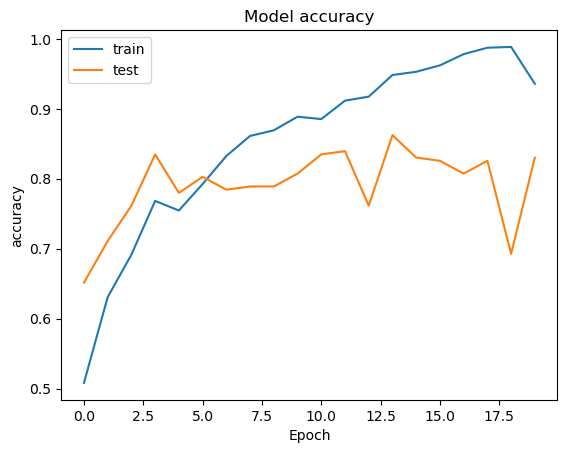

In [21]:
plt.plot(histor.history['accuracy'])
plt.plot(histor.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])

In [22]:
y_pred=np.argmax(cnn.predict(X_test),axis=1)

7/7 [==============================] - 0s 42ms/step
